In [1]:
import re
import ast

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from ast import literal_eval
from collections import OrderedDict

sns.set()
%matplotlib inline

In [2]:
feature_categories = [
    'Shape', 
    'Clinical',
    'First Order', 
    'GLCM', 
    'GLRLM', 
    'GLSZM', 
    'GLDM', 
    'NGTDM', 
    'PET parameter',
]

In [3]:
def get_palette_colour(label):
    
    palette = sns.color_palette('colorblind', n_colors=len(feature_categories))
    mapping = {
        'Shape': palette[0], 
        'Clinical': palette[1],
        'First Order': palette[2], 
        'GLCM': palette[3], 
        'GLRLM': palette[4], 
        'GLSZM': palette[5], 
        'GLDM': palette[6], 
        'NGTDM': palette[7], 
        'PET parameter': palette[8]
    }
    return mapping[label]

In [4]:
def feature_categories_from_labels(labels):    
    """Translates feature labels into feature categories."""
    keys = []
    for label in labels:
        if 'shape' in label:
            keys.append('Shape')
        elif 'firstorder' in label:
            keys.append('First Order')
        elif 'glcm' in label:
            keys.append('GLCM')
        elif 'glrlm' in label:
            keys.append('GLRLM')
        elif 'glszm' in label:
            keys.append('GLSZM')
        elif 'gldm' in label:
            keys.append('GLDM')
        elif 'ngtdm' in label:
            keys.append('NGTDM')
        elif 'PETparam' in label:
            keys.append('PET parameter')
        else:
            keys.append('Clinical')

    return keys

In [5]:
def format_feature_labels(labels):
    """Process raw feature labels."""
    prep_labels = []
    for label in labels:
        #print(label)
        comps = label.split('_')
        if len(comps) == 1:
            prep_labels.append(label.title())
        elif len(comps) == 2:
            new_label = f'{comps[0]}: {comps[1]}'
            prep_labels.append(new_label)
        elif len(comps) == 3:
            filter_type, feature_type, name = comps
            if len(name) > 15:
                new_label = '{}'.format(name)
            else:
                new_label = '{}'.format(name)
            prep_labels.append(new_label)
        elif len(comps) == 4:
            image_type, filter_type, feature_type, name = comps
            if len(name) > 15:
                new_label = f'\n{image_type} {name}'
            else:
                new_label = f'{image_type} {name}'
            prep_labels.append(new_label)
        elif len(comps) == 5:
            image_type, _, _, name, _ = comps
            if len(name) > 15:
                new_label = f'\n{image_type} {name}'
            else:
                new_label = f'{image_type} {name}'
            prep_labels.append(new_label)
        else:
            raise ValueError('Label more than 5 comps!')
            
    return prep_labels

In [6]:
def extract_votes(votes, X, feature_labels, clinical):
    """Collects selected feature votes from experimental results.
    
    Args:
        votes (): The votes column from results DataFrame.
        X (): The feature matrix used in the experiment.
        feature_labels(): 
    
    """
    
    votes_bk = np.zeros(X.shape[1], dtype=int)
    
    # Format string of feature votes into ndarray and accumulate votes.
    for str_array in votes:
        str_array = str_array[1:-1].strip()
        run_votes = str_array.replace('  ', ' ')
        run_votes = run_votes.strip()
        run_votes = run_votes.replace(' ', ',')
        run_votes = run_votes.lstrip(',')
        run_votes = f'[{run_votes}]'
        votes_arr = np.array(ast.literal_eval(run_votes), dtype=np.int32)
        votes_bk += votes_arr

    idx = np.argsort(votes_bk)[::-1]
    sorted_votes = np.trim_zeros(votes_bk[idx], trim='b')
 
    labels = np.array(feature_labels)[idx]    
    sorted_feature_labels = labels[:len(sorted_votes)]

    # NOTE: Scaling factor is derived from
    #    num random states * num classifiers * num feature selectors * num outer folds
    #    = 40 * 5 * 7 * 10
    sorted_votes = sorted_votes / 14000 
    data = pd.DataFrame({'votes': sorted_votes, 'labels': sorted_feature_labels})

    # Group the encoded clinical variables and scale by number of encoded members:
    # 1. Extract and format the clinical feature votes.
    # 2. Remove the encoded clinical feature votes from the vote bookeeper.
    # 3. Insert the formatted clinical feature votes.

    # To accumulate votes.
    votes_noncoded_clinical = {
        'ICD-10': 0, 
        'T Stage': 0, 
        'N Stage': 0, 
        'Stage': 0, 
        'Histology': 0,
        'HPV': 0,
        'ECOG': 0,
        'Charlson': 0,
        'Cisplatin': 0,
        'Stage': 0
    }
    # Delete row from data.
    num_encodings_tracker = {
        'ICD-10': 0, 
        'T Stage': 0, 
        'N Stage': 0, 
        'Stage': 0, 
        'Histology': 0,
        'HPV': 0,
        'ECOG': 0,
        'Charlson': 0,
        'Cisplatin': 0,
    }
    to_drop = []
    for col in clinical.columns:
        match = data[data['labels'] == col]
        if not match.empty:
            vote, label = np.squeeze(match.values)
            if 'ICD-10' in label:
                votes_noncoded_clinical['ICD-10'] += float(vote)
                num_encodings_tracker['ICD-10'] += 1
                to_drop.append(int(match.index[0]))
            if 'Histology' in label:
                votes_noncoded_clinical['Histology'] += float(vote)
                num_encodings_tracker['Histology'] += 1
                to_drop.append(int(match.index[0]))
            if 'HPV' in label:
                votes_noncoded_clinical['HPV'] += float(vote)
                num_encodings_tracker['HPV'] += 1    
                to_drop.append(int(match.index[0]))
            if 'ECOG' in label:
                votes_noncoded_clinical['ECOG'] += float(vote)
                num_encodings_tracker['ECOG'] += 1   
                to_drop.append(int(match.index[0]))
            if 'Charlson' in label:
                votes_noncoded_clinical['Charlson'] += float(vote)
                num_encodings_tracker['Charlson'] += 1 
                to_drop.append(int(match.index[0]))
            if 'Cisplatin' in label:
                votes_noncoded_clinical['Cisplatin'] += float(vote)
                num_encodings_tracker['Cisplatin'] += 1  
                to_drop.append(int(match.index[0]))
            if 'T Stage' in label:
                votes_noncoded_clinical['T Stage'] += float(vote)
                num_encodings_tracker['T Stage'] += 1  
                to_drop.append(int(match.index[0]))
            if 'N Stage' in label:
                votes_noncoded_clinical['N Stage'] += float(vote)
                num_encodings_tracker['N Stage'] += 1 
                to_drop.append(int(match.index[0]))
            if 'Stage' in label:
                if 'T Stage' in label:
                    pass
                elif 'T Stage' in label:
                    pass
                else:
                    votes_noncoded_clinical['Stage'] += float(vote)
                    num_encodings_tracker['Stage'] += 1 
                    to_drop.append(int(match.index[0]))

    # Scale votes by the number of encodings.
    row_idx = data.index[-1] + 1
    for num, (key, value) in enumerate(votes_noncoded_clinical.items()):
        votes_noncoded_clinical[key] /= (num_encodings_tracker[key] + 1e-20)

    # Drop votes on encoded clinical variable.
    data.drop(to_drop, inplace=True, axis=0)
    data.reset_index(drop=True, inplace=True)

    tmp_df = pd.DataFrame([votes_noncoded_clinical.values(), votes_noncoded_clinical.keys()]).T
    tmp_df.columns = ['votes', 'labels']
    tmp_df.index = np.arange(data.index[-1] + 1, data.index[-1] + 1 + tmp_df.shape[0])

    data = data.append(tmp_df)

    return data

In [7]:
# GLobals.
clinical = pd.read_csv(
    './../../data_source/to_analysis/clinical_params.csv', index_col=0
)
SHAPE_LARGE = (15, 7)
SHAPE_SMALL = (12, 7)

# Original Images

In [2]:
X_orig = pd.read_csv(
    './../../data_source/to_analysis/original_images/all_features_original_images.csv',
    index_col=0
)
results_orig = pd.read_csv(
    './../../data_source/results/original_images/results_all_features_original_images.csv',
    index_col=0
)
results_orig.head()

,exp_id,experiment_id,QuadraticDiscriminantEstimator__reg_param,test_score,train_score,test_score_variance,train_score_variance,feature_votes,target_test_support,target_train_support,...,RFEstimator__n_estimators,KNNEstimator__leaf_size,KNNEstimator__metric,KNNEstimator__n_neighbors,KNNEstimator__p,DTreeEstimator__criterion,DTreeEstimator__max_depth,DTreeEstimator__max_features,DTreeEstimator__min_samples_leaf,exp_duration
0,0,DummySelection_QuadraticDiscriminantEstimator,0.000093,0.573718,0.994155,0.005760,0.000023,[5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5...,[0 0],[670 320],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3,DummySelection_QuadraticDiscriminantEstimator,0.001000,0.558974,0.968854,0.006729,0.000272,[5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5...,[0 0],[670 320],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,DummySelection_QuadraticDiscriminantEstimator,0.001000,0.558974,0.968854,0.006729,0.000272,[5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5...,[0 0],[670 320],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,39,DummySelection_QuadraticDiscriminantEstimator,0.320837,0.548077,0.747602,0.003981,0.000360,[5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5...,[0 0],[670 320],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,9,DummySelection_QuadraticDiscriminantEstimator,0.001000,0.562821,0.972624,0.001580,0.000055,[5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5...,[0 0],[670 320],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
np.unique(results_orig['experiment_id'])

array(['ChiSquareSelection_DTreeEstimator',
       'ChiSquareSelection_ExtraTreesEstimator',
       'ChiSquareSelection_KNNEstimator', 'ChiSquareSelection_LightGBM',
       'ChiSquareSelection_LogRegEstimator',
       'ChiSquareSelection_QuadraticDiscriminantEstimator',
       'ChiSquareSelection_RFEstimator',
       'ChiSquareSelection_RidgeClassifier',
       'ChiSquareSelection_SVCEstimator', 'ChiSquareSelection_XGBoost',
       'DummySelection_DTreeEstimator',
       'DummySelection_ExtraTreesEstimator',
       'DummySelection_KNNEstimator', 'DummySelection_LightGBM',
       'DummySelection_LogRegEstimator',
       'DummySelection_QuadraticDiscriminantEstimator',
       'DummySelection_RFEstimator', 'DummySelection_RidgeClassifier',
       'DummySelection_SVCEstimator', 'DummySelection_XGBoost',
       'FisherScoreSelection_DTreeEstimator',
       'FisherScoreSelection_ExtraTreesEstimator',
       'FisherScoreSelection_KNNEstimator',
       'FisherScoreSelection_LightGBM',
       '

In [9]:
orig_feature_labels = list(X_orig.columns)

In [77]:
orig_data = extract_votes(
    results_orig['feature_votes'], X_orig, orig_feature_labels, clinical
)

In [78]:
# NOTE: Use cat from labels to map a label to a cat and get the tot num feats from that cat.
keys = [
    'Shape', 'Clinical', 'PET Parameter', 'CT Texture', 
    'PET Texture', 'CT First Order', 'PET First Order'
]
textures = ['glcm', 'glrlm', 'glszm', 'gldm', 'ngtdm']

feats_per_cat = dict.fromkeys(keys, 0)
for label in X_orig.columns:
    if 'CT_original_firstorder' in label:
        feats_per_cat['CT First Order'] += 1
    elif 'PET_original_firstorder' in label:
        feats_per_cat['PET First Order'] += 1
    elif any(f'CT_original_{text}' in label for text in textures):
        feats_per_cat['CT Texture'] += 1
    elif any(f'PET_original_{text}' in label for text in textures):
        feats_per_cat['PET Texture'] += 1
    elif 'shape' in label:
        feats_per_cat['Shape'] += 1
    elif 'PETparam' in label:
        feats_per_cat['PET Parameter'] += 1
    else:
        pass

# Clinical.
feats_per_cat['Clinical'] += 13

{'Shape': 14,
 'Clinical': 13,
 'PET Parameter': 3,
 'CT Texture': 204,
 'PET Texture': 204,
 'CT First Order': 25,
 'PET First Order': 21}

In [85]:
accumul_votes = dict.fromkeys(feats_per_cat.keys(), 0)
num_votes = dict.fromkeys(feats_per_cat.keys(), 0)

textures = ['glcm', 'glrlm', 'glszm', 'gldm', 'ngtdm']
for num, label in enumerate(orig_data.loc[:, 'labels']):
    if 'shape' in label:
        accumul_votes['Shape'] += orig_data.iloc[num, 0]
        num_votes['Shape'] += 1
    elif 'PETparam' in label:
        accumul_votes['PET Parameter'] += orig_data.iloc[num, 0]
        num_votes['PET Parameter'] += 1
    elif 'CT_original_firstorder' in label:
        accumul_votes['CT First Order'] += orig_data.iloc[num, 0]
        num_votes['CT First Order'] += 1
    elif 'PET_original_firstorder' in label:
        accumul_votes['PET First Order'] += orig_data.iloc[num, 0]
        num_votes['PET First Order'] += 1
    elif any(f'CT_original_{text}' in label for text in textures):
        accumul_votes['CT Texture'] += orig_data.iloc[num, 0]
        num_votes['CT Texture'] += 1
    elif any(f'PET_original_{text}' in label for text in textures):
        accumul_votes['PET Texture'] += orig_data.iloc[num, 0]
        num_votes['PET Texture'] += 1
    else:
        # Clinical.
        accumul_votes['Clinical'] += orig_data.iloc[num, 0]
        num_votes['Clinical'] += 1

In [86]:
accumul_votes

{'Shape': 5.8722142857142865,
 'Clinical': 2.6722255102040817,
 'PET Parameter': 0.5536428571428571,
 'CT Texture': 32.73899999999997,
 'PET Texture': 35.350285714285704,
 'CT First Order': 4.583285714285714,
 'PET First Order': 3.465785714285715}

In [87]:
accumul_votes = {
    key: value / num_votes[key] for key, value in accumul_votes.items()
}
accumul_votes

{'Shape': 0.41944387755102047,
 'Clinical': 0.20555580847723706,
 'PET Parameter': 0.18454761904761904,
 'CT Texture': 0.1604852941176469,
 'PET Texture': 0.17328571428571424,
 'CT First Order': 0.18333142857142856,
 'PET First Order': 0.16503741496598642}

In [40]:
orig_data.iloc[num, 0]

0.20020238095238096

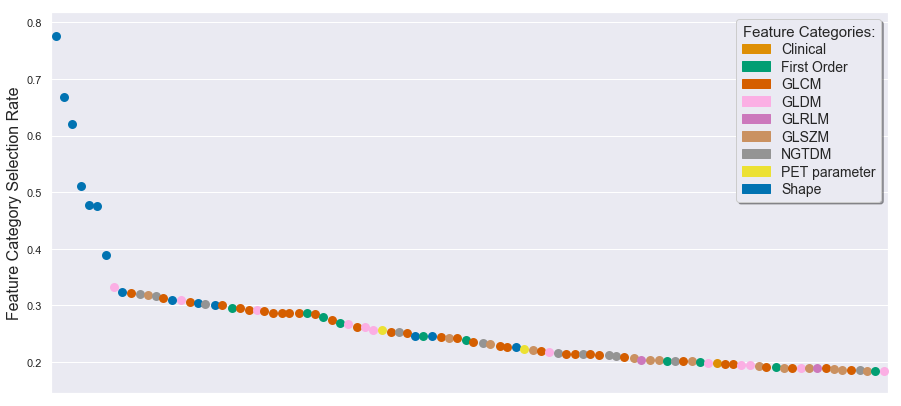

In [11]:
n = 100
sub_data = orig_data.iloc[:n, :]
fnames = format_feature_labels(sub_data['labels'])
keys = feature_categories_from_labels(sub_data['labels'])

feature_category_to_colour = {}
for label in np.unique(keys):
    feature_category_to_colour[label] = get_palette_colour(label)     
    
handles = [
    mpatches.Patch(color=feature_category_to_colour[key], label=key) 
    for key in np.unique(keys)
]
plt.figure(figsize=SHAPE_LARGE)
#plt.title(f'The {n} Most Frequently Selected Features', fontsize=18)
fig = sns.stripplot(
    x='labels',
    y='votes',
    data=sub_data,
    size=9,
    hue=keys,
    palette=feature_category_to_colour
)

feature_id = np.arange(n)
plt.ylabel('Feature Category Selection Rate', fontsize=16)
plt.xlabel('')
plt.xticks([], [])

plt.legend(
    handles=handles,
    title='Feature Categories:', 
    title_fontsize=15,
    #loc='upper center', 
    #bbox_to_anchor=(0.89, 1),
    fancybox=True, 
    shadow=True, 
    fontsize=14,
    ncol=1,
    labelspacing=0.25
)
"""
plt.savefig(
    './../../figures/feature_importances/baseline_selected_feats.png',
    bbox_inches='tight',
    dpi=100, 
)
"""

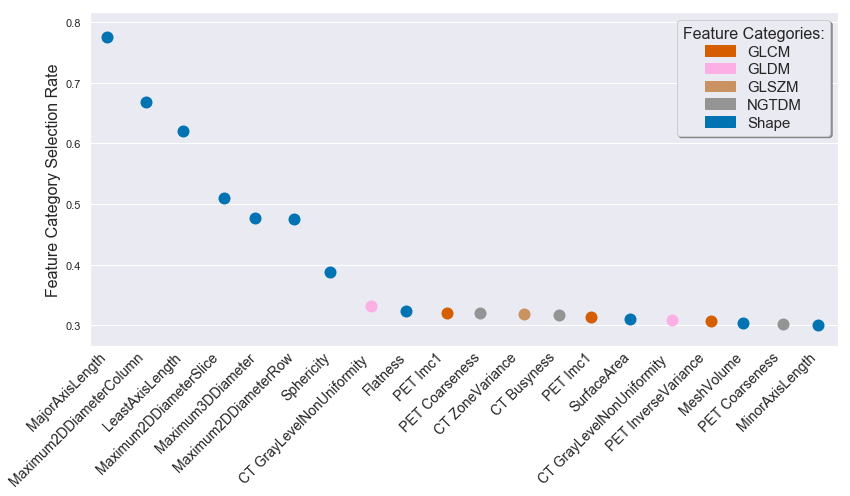

In [12]:
n = 20
sub_data = orig_data.iloc[:n, :]
fnames = format_feature_labels(sub_data['labels'])
keys = feature_categories_from_labels(sub_data['labels'])

feature_category_to_colour = {}
for label in np.unique(keys):
    feature_category_to_colour[label] = get_palette_colour(label)     
    
handles = [
    mpatches.Patch(color=feature_category_to_colour[key], label=key) 
    for key in np.unique(keys)
]

plt.figure(figsize=SHAPE_SMALL)
#plt.title(f'Top {n} Most Frequently Selected Features', fontsize=16)
fig = sns.stripplot(
    y='votes',
    x='labels',
    data=sub_data,
    hue=keys,
    size=12,
    edgecolor='k',
    palette=feature_category_to_colour
)
#markerline, stemlines, baseline = plt.stem(
#    np.arange(n), sub_data['votes'], 
#    linefmt='b-.', markerfmt=' ', bottom=0
#)
#plt.setp(stemlines, 'linewidth', 1)
#plt.setp(baseline, 'linewidth', 0)
feature_id = np.arange(n)
plt.xlabel('')
plt.ylabel('Feature Category Selection Rate', fontsize=16)

plt.xticks(np.arange(len(fnames)), fnames, fontsize=14, 
           rotation=45, ha='right', va='center_baseline')

plt.legend(
    handles=handles,
    title='Feature Categories:', 
    title_fontsize=16,
    fancybox=True, 
    shadow=True, 
    fontsize=15,
    labelspacing=0.25
)
plt.tight_layout()
plt.savefig(
    './../../figures/feature_importances/orig_top_n_selected_feats.png',
    bbox_inches='tight',
    dpi=100, 
)

In [13]:
model_name = 'MultiSURFSelection_LightGBM'
orig_model_votes = results_orig[results_orig['experiment_id'] == model_name]['feature_votes']
orig_model_votes = extract_votes(
    orig_model_votes, X_orig, orig_feature_labels, clinical
)

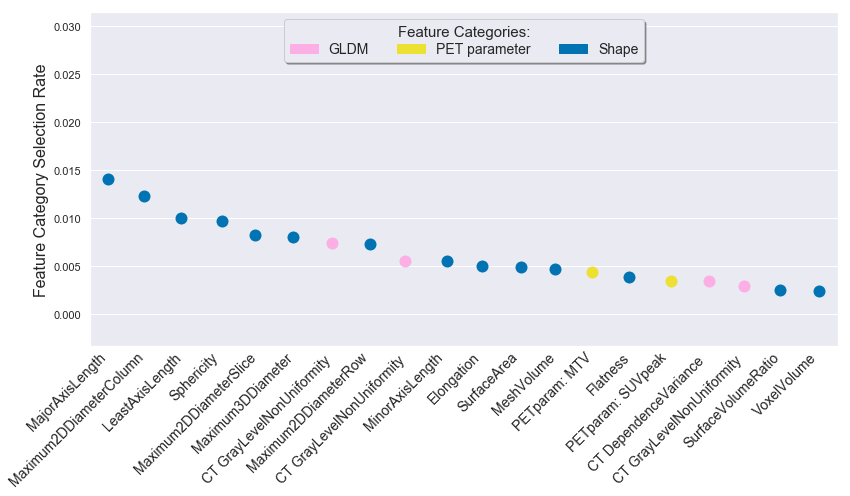

In [14]:
n = 20
sub_data = orig_model_votes.iloc[:n, :]
fnames = format_feature_labels(sub_data['labels'])
keys = feature_categories_from_labels(sub_data['labels'])

feature_category_to_colour = {}
for label in np.unique(keys):
    feature_category_to_colour[label] = get_palette_colour(label)     
    
handles = [
    mpatches.Patch(color=feature_category_to_colour[key], label=key) 
    for key in np.unique(keys)
]

plt.figure(figsize=SHAPE_SMALL)
#plt.title(f'Top {n} Most Frequently Selected Features', fontsize=16)
fig = sns.stripplot(
    y='votes',
    x='labels',
    data=sub_data,
    hue=keys,
    size=12,
    edgecolor='k',
    palette=feature_category_to_colour
)
#markerline, stemlines, baseline = plt.stem(
#    np.arange(n), sub_data['votes'], 
#    linefmt='b-.', markerfmt=' ', bottom=0
#)
#plt.setp(stemlines, 'linewidth', 1)
#plt.setp(baseline, 'linewidth', 0)
feature_id = np.arange(n)
plt.xlabel('')
plt.ylabel('Feature Category Selection Rate', fontsize=16)

plt.xticks(np.arange(len(fnames)), fnames, fontsize=14, 
           rotation=45, ha='right', va='center_baseline')

plt.legend(
    handles=handles,
    title='Feature Categories:', 
    title_fontsize=15,
    loc='upper center', 
    bbox_to_anchor=(0.5, 1),
    fancybox=True, 
    shadow=True, 
    fontsize=14,
    ncol=4,
    labelspacing=0.25
)
plt.tight_layout()
plt.savefig(
    './../../figures/feature_importances/light_gbm_top_n_sel.png',
    bbox_inches='tight',
    dpi=100, 
)

# Removed Broken Slices

In [15]:
X_red = pd.read_csv(
    './../../data_source/to_analysis/removed_broken_slices/all_features_removed_broken_slices.csv',
    index_col=0
)
results_red = pd.read_csv(
    './../../data_source/results/removed_broken_slices/results_all_features_removed_broken_slices.csv',
    index_col=0
)
results_red.head()

,exp_id,experiment_id,QuadraticDiscriminantEstimator__reg_param,test_score,train_score,test_score_variance,train_score_variance,feature_votes,target_test_support,target_train_support,...,RFEstimator__min_samples_leaf,RFEstimator__n_estimators,KNNEstimator__leaf_size,KNNEstimator__metric,KNNEstimator__n_neighbors,KNNEstimator__p,DTreeEstimator__criterion,DTreeEstimator__max_depth,DTreeEstimator__max_features,DTreeEstimator__min_samples_leaf
0,0,DummySelection_QuadraticDiscriminantEstimator,0.611062,0.565676,0.748192,0.003102,0.000918,[5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5...,[0 0],[640 295],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3,DummySelection_QuadraticDiscriminantEstimator,0.369797,0.599275,0.778007,0.017894,0.001178,[5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5...,[0 0],[640 295],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,DummySelection_QuadraticDiscriminantEstimator,0.369797,0.599275,0.778007,0.017894,0.001178,[5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5...,[0 0],[640 295],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,39,DummySelection_QuadraticDiscriminantEstimator,0.268076,0.578853,0.782655,0.012575,0.000866,[5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5...,[0 0],[640 295],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,9,DummySelection_QuadraticDiscriminantEstimator,0.001188,0.631368,0.987278,0.002011,0.000064,[5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5...,[0 0],[640 295],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
red_feature_labels = list(X_red.columns)

In [17]:
red_data = extract_votes(
    results_red['feature_votes'], X_red, red_feature_labels, clinical
)

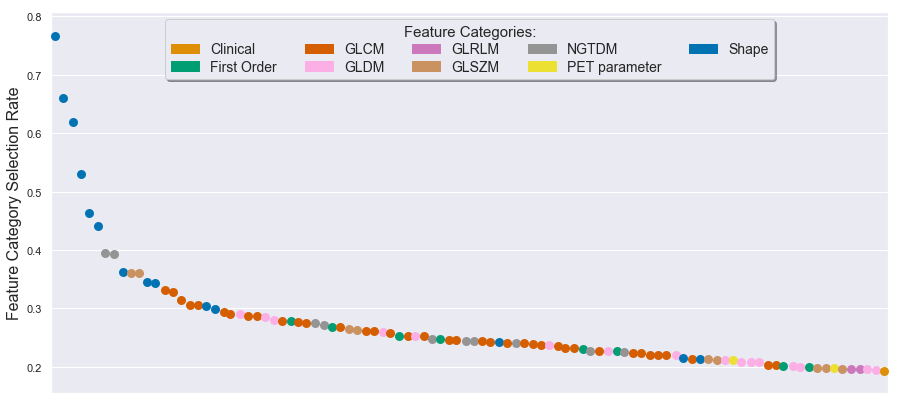

In [18]:
# Observations:
# * Appears NGTDM features are more frequently selected after removing broken slices.
# * All top n features seleceted are also the top n features selected by the best model (Fisher + LightGBM).

n = 100
sub_data = red_data.iloc[:n, :]
fnames = format_feature_labels(sub_data['labels'])
keys = feature_categories_from_labels(sub_data['labels'])

feature_category_to_colour = {}
for label in np.unique(keys):
    feature_category_to_colour[label] = get_palette_colour(label)     
    
handles = [
    mpatches.Patch(color=feature_category_to_colour[key], label=key) 
    for key in np.unique(keys)
]

plt.figure(figsize=SHAPE_LARGE)
#plt.title(f'Top {n} Most Frequently Selected Features', fontsize=16)
fig = sns.stripplot(
    x='labels',
    y='votes',
    data=sub_data,
    size=9,
    hue=keys,
    palette=feature_category_to_colour
)
feature_id = np.arange(n)
plt.ylabel('Feature Category Selection Rate', fontsize=16)
plt.xlabel('')
plt.xticks([], [])

plt.legend(
    handles=handles,
    title='Feature Categories:', 
    title_fontsize=15,
    loc='upper center', 
    bbox_to_anchor=(0.5, 1),
    fancybox=True, 
    shadow=True, 
    fontsize=14,
    ncol=5,
    labelspacing=0.25
)
plt.savefig(
    './../../figures/feature_importances/red_selected_feats.png',
    bbox_inches='tight',
    dpi=100, 
)

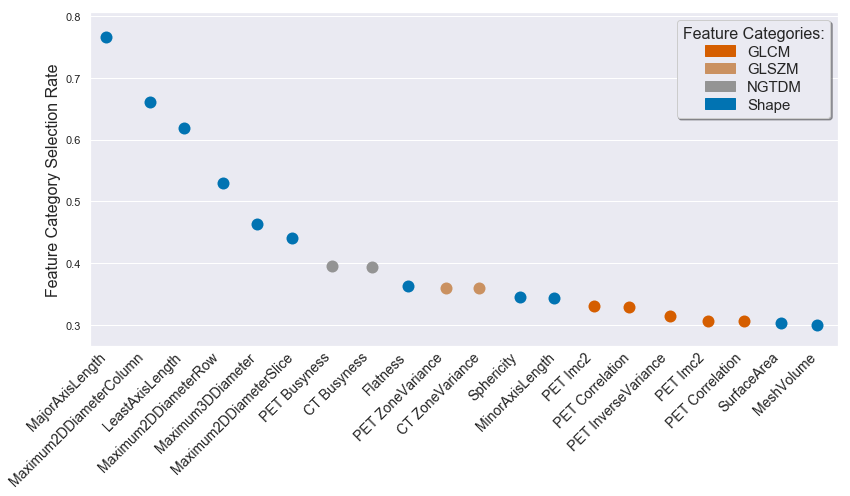

In [19]:
n = 20
sub_data = red_data.iloc[:n, :]
fnames = format_feature_labels(sub_data['labels'])
keys = feature_categories_from_labels(sub_data['labels'])

feature_category_to_colour = {}
for label in np.unique(keys):
    feature_category_to_colour[label] = get_palette_colour(label)     
    
handles = [
    mpatches.Patch(color=feature_category_to_colour[key], label=key) 
    for key in np.unique(keys)
]

plt.figure(figsize=SHAPE_SMALL)
#plt.title(f'Top {n} Most Frequently Selected Features', fontsize=16)
fig = sns.stripplot(
    y='votes',
    x='labels',
    data=sub_data,
    hue=keys,
    size=12,
    edgecolor='k',
    palette=feature_category_to_colour
)
#markerline, stemlines, baseline = plt.stem(
#    np.arange(n), sub_data['votes'], 
#    linefmt='b-.', markerfmt=' ', bottom=0
#)
#plt.setp(stemlines, 'linewidth', 1)
#plt.setp(baseline, 'linewidth', 0)
feature_id = np.arange(n)
plt.xlabel('')
plt.ylabel('Feature Category Selection Rate', fontsize=16)

plt.xticks(np.arange(len(fnames)), fnames, fontsize=14, 
           rotation=45, ha='right', va='center_baseline')

plt.legend(
    handles=handles,
    title='Feature Categories:', 
    title_fontsize=16,
    fancybox=True, 
    shadow=True, 
    fontsize=15,
    labelspacing=0.25
)
plt.tight_layout()
plt.savefig(
    './../../figures/feature_importances/red_top_b_selected_feats.png',
    bbox_inches='tight',
    dpi=100, 
)

In [20]:
#np.unique(results_red['experiment_id'])

In [21]:
model_name = 'FisherScoreSelection_SVCEstimator'
red_model_votes = results_red[results_red['experiment_id'] == model_name]['feature_votes']
red_model_votes = extract_votes(
    red_model_votes, X_red, red_feature_labels, clinical
)

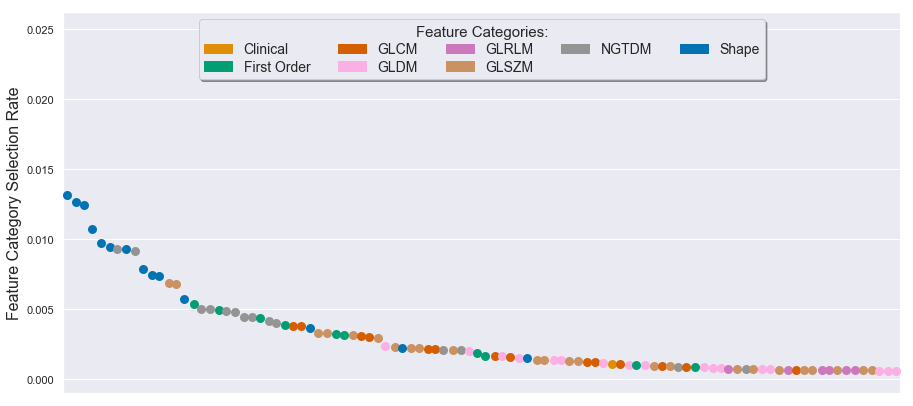

In [22]:
n = 100
sub_data = red_model_votes.iloc[:n, :]
fnames = format_feature_labels(sub_data['labels'])
keys = feature_categories_from_labels(sub_data['labels'])

feature_category_to_colour = {}
for label in np.unique(keys):
    feature_category_to_colour[label] = get_palette_colour(label)     
    
handles = [
    mpatches.Patch(color=feature_category_to_colour[key], label=key) 
    for key in np.unique(keys)
]

plt.figure(figsize=SHAPE_LARGE)
#plt.title(f'Top {n} Most Frequently Selected Features', fontsize=16)
fig = sns.stripplot(
    x='labels',
    y='votes',
    data=sub_data,
    size=9,
    hue=keys,
    palette=feature_category_to_colour
)
feature_id = np.arange(n)
plt.ylabel('Feature Category Selection Rate', fontsize=16)
plt.xlabel('')
plt.xticks([], [])

plt.legend(
    handles=handles,
    title='Feature Categories:', 
    title_fontsize=15,
    loc='upper center', 
    bbox_to_anchor=(0.5, 1),
    fancybox=True, 
    shadow=True, 
    fontsize=14,
    ncol=5,
    labelspacing=0.25
)
plt.savefig(
    './../../figures/feature_importances/fisher_svc_red_selected_feats.png',
    bbox_inches='tight',
    dpi=100, 
)

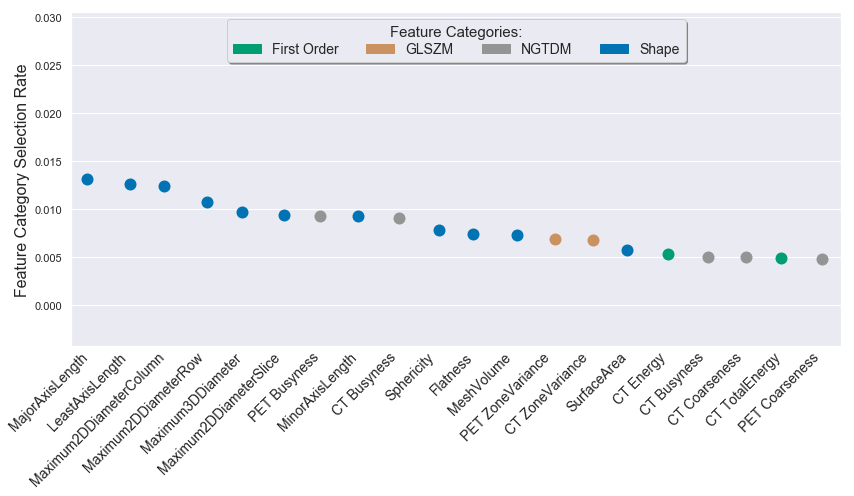

In [23]:
n = 20
sub_data = red_model_votes.iloc[:n, :]
fnames = format_feature_labels(sub_data['labels'])
keys = feature_categories_from_labels(sub_data['labels'])

feature_category_to_colour = {}
for label in np.unique(keys):
    feature_category_to_colour[label] = get_palette_colour(label)     
    
handles = [
    mpatches.Patch(color=feature_category_to_colour[key], label=key) 
    for key in np.unique(keys)
]

plt.figure(figsize=SHAPE_SMALL)
#plt.title(f'Top {n} Most Frequently Selected Features', fontsize=16)
fig = sns.stripplot(
    y='votes',
    x='labels',
    data=sub_data,
    hue=keys,
    size=12,
    edgecolor='k',
    palette=feature_category_to_colour
)
#markerline, stemlines, baseline = plt.stem(
#    np.arange(n), sub_data['votes'], 
#    linefmt='b-.', markerfmt=' ', bottom=0
#)
#plt.setp(stemlines, 'linewidth', 1)
#plt.setp(baseline, 'linewidth', 0)
feature_id = np.arange(n)
plt.xlabel('')
plt.ylabel('Feature Category Selection Rate', fontsize=16)

plt.xticks(np.arange(len(fnames)), fnames, fontsize=14, 
           rotation=45, ha='right', va='center_baseline')

plt.legend(
    handles=handles,
    title='Feature Categories:', 
    title_fontsize=15,
    loc='upper center', 
    bbox_to_anchor=(0.5, 1),
    fancybox=True, 
    shadow=True, 
    fontsize=14,
    ncol=4,
    labelspacing=0.25
)
plt.tight_layout()
plt.savefig(
    './../../figures/feature_importances/fisher_svc_red_top_b_selected_feats.png',
    bbox_inches='tight',
    dpi=100, 
)

# Removed ICC and SCC

In [24]:
X_icc_scc = pd.read_csv(
    './../../data_source/to_analysis/compressed_features/all_features_orig_images_icc_dropped.csv',
    index_col=0
)
results_icc_scc = pd.read_csv(
    './../../data_source/results/dropped_corr/results_all_features_original_images_icc_dropped_correlated.csv',
    index_col=0
)
results_icc_scc.head()

,exp_id,experiment_id,QuadraticDiscriminantEstimator__reg_param,test_score,train_score,test_score_variance,train_score_variance,feature_votes,target_test_support,target_train_support,...,RFEstimator__min_samples_leaf,RFEstimator__n_estimators,KNNEstimator__leaf_size,KNNEstimator__metric,KNNEstimator__n_neighbors,KNNEstimator__p,DTreeEstimator__criterion,DTreeEstimator__max_depth,DTreeEstimator__max_features,DTreeEstimator__min_samples_leaf
0,0,DummySelection_QuadraticDiscriminantEstimator,0.112433,0.565527,0.705015,0.003829,0.000123,[5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5...,[0 0],[670 320],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3,DummySelection_QuadraticDiscriminantEstimator,0.703936,0.622934,0.678459,0.011208,0.000234,[5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5...,[0 0],[670 320],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,DummySelection_QuadraticDiscriminantEstimator,0.703936,0.622934,0.678459,0.011208,0.000234,[5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5...,[0 0],[670 320],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,39,DummySelection_QuadraticDiscriminantEstimator,0.533001,0.570869,0.694415,0.002408,0.000379,[5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5...,[0 0],[670 320],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,9,DummySelection_QuadraticDiscriminantEstimator,0.590595,0.580484,0.693751,0.001866,0.000386,[5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5...,[0 0],[670 320],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
icc_scc_feature_labels = list(X_icc_scc.columns)

In [26]:
icc_scc_data = extract_votes(
    results_icc_scc['feature_votes'], X_icc_scc, icc_scc_feature_labels, clinical
)

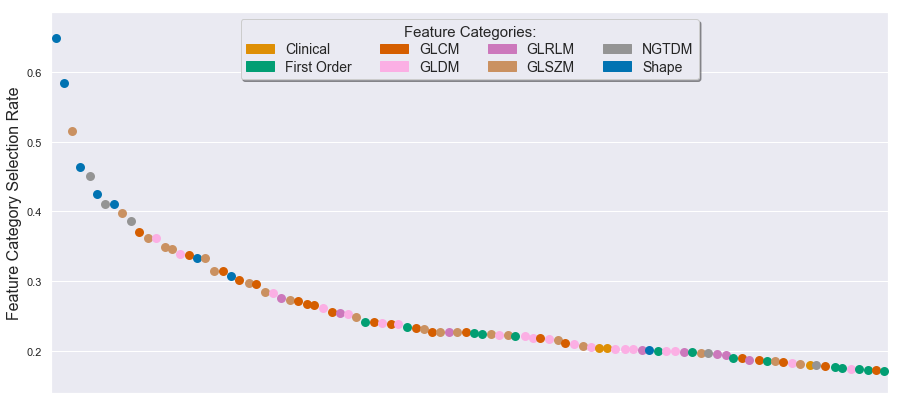

In [27]:
# Observations:
# * Appears NGTDM features are more frequently selected after removing broken slices.
# * All top n features seleceted are also the top n features selected by the best model (Fisher + LightGBM).

n = 100
sub_data = icc_scc_data.iloc[:n, :]
fnames = format_feature_labels(sub_data['labels'])
keys = feature_categories_from_labels(sub_data['labels'])

feature_category_to_colour = {}
for label in np.unique(keys):
    feature_category_to_colour[label] = get_palette_colour(label)     
    
handles = [
    mpatches.Patch(color=feature_category_to_colour[key], label=key) 
    for key in np.unique(keys)
]

plt.figure(figsize=SHAPE_LARGE)
#plt.title(f'Top {n} Most Frequently Selected Features', fontsize=16)
fig = sns.stripplot(
    x='labels',
    y='votes',
    data=sub_data,
    size=9,
    hue=keys,
    palette=feature_category_to_colour
)
feature_id = np.arange(n)
plt.ylabel('Feature Category Selection Rate', fontsize=16)
plt.xlabel('')
plt.xticks([], [])

plt.legend(
    handles=handles,
    title='Feature Categories:', 
    title_fontsize=15,
    loc='upper center', 
    bbox_to_anchor=(0.5, 1),
    fancybox=True, 
    shadow=True, 
    fontsize=14,
    ncol=4,
    labelspacing=0.25
)
plt.savefig(
    './../../figures/feature_importances/icc_scc_selected_feats.png',
    bbox_inches='tight',
    dpi=100, 
)

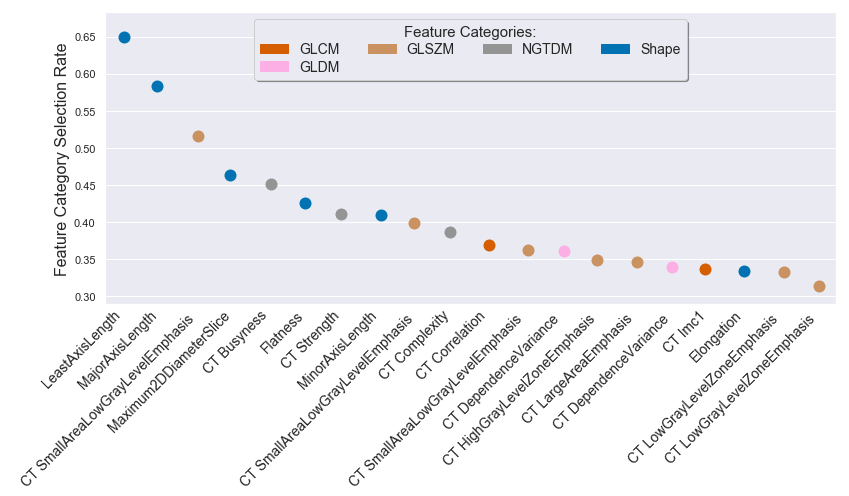

In [28]:
n = 20
sub_data = icc_scc_data.iloc[:n, :]
fnames = format_feature_labels(sub_data['labels'])
keys = feature_categories_from_labels(sub_data['labels'])

feature_category_to_colour = {}
for label in np.unique(keys):
    feature_category_to_colour[label] = get_palette_colour(label)     
    
handles = [
    mpatches.Patch(color=feature_category_to_colour[key], label=key) 
    for key in np.unique(keys)
]

plt.figure(figsize=SHAPE_SMALL)
#plt.title(f'Top {n} Most Frequently Selected Features', fontsize=16)
fig = sns.stripplot(
    y='votes',
    x='labels',
    data=sub_data,
    hue=keys,
    size=12,
    edgecolor='k',
    palette=feature_category_to_colour
)
#markerline, stemlines, baseline = plt.stem(
#    np.arange(n), sub_data['votes'], 
#    linefmt='b-.', markerfmt=' ', bottom=0
#)
#plt.setp(stemlines, 'linewidth', 1)
#plt.setp(baseline, 'linewidth', 0)
feature_id = np.arange(n)
plt.xlabel('')
plt.ylabel('Feature Category Selection Rate', fontsize=16)

plt.xticks(np.arange(len(fnames)), fnames, fontsize=14, 
           rotation=45, ha='right', va='center_baseline')

plt.legend(
    handles=handles,
    title='Feature Categories:', 
    title_fontsize=15,
    loc='upper center', 
    bbox_to_anchor=(0.5, 1),
    fancybox=True, 
    shadow=True, 
    fontsize=14,
    ncol=4,
    labelspacing=0.25
)
plt.tight_layout()
plt.savefig(
    './../../figures/feature_importances/icc_scc_top_b_selected_feats.png',
    bbox_inches='tight',
    dpi=100, 
)

# HPV splitting Group B

In [33]:
X_hpv_b = pd.read_csv(
    './../../data_source/to_analysis/hpv_splitting/all_features_orig_images_icc_dropped_hpv_group_b.csv',
    index_col=0
)
results_hpv_b = pd.read_csv(
    './../../data_source/results/hpv_splitting/results_all_features_hpv_group_b.csv',
    index_col=0
)
results_hpv_b.head()

,exp_id,experiment_id,QuadraticDiscriminantEstimator__reg_param,test_score,train_score,test_score_variance,train_score_variance,feature_votes,target_test_support,target_train_support,...,RFEstimator__min_samples_leaf,RFEstimator__n_estimators,KNNEstimator__leaf_size,KNNEstimator__metric,KNNEstimator__n_neighbors,KNNEstimator__p,DTreeEstimator__criterion,DTreeEstimator__max_depth,DTreeEstimator__max_features,DTreeEstimator__min_samples_leaf
0,0,DummySelection_QuadraticDiscriminantEstimator,0.041602,0.508333,0.654983,0.030833,0.001848,[10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 ...,[0 0],[360 310],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3,DummySelection_QuadraticDiscriminantEstimator,0.001000,0.512500,0.940520,0.026406,0.000848,[10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 ...,[0 0],[360 310],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,DummySelection_QuadraticDiscriminantEstimator,0.001000,0.512500,0.940520,0.026406,0.000848,[10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 ...,[0 0],[360 310],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,39,DummySelection_QuadraticDiscriminantEstimator,0.003504,0.554167,0.889047,0.019809,0.000743,[10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 ...,[0 0],[360 310],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,9,DummySelection_QuadraticDiscriminantEstimator,0.000020,0.600000,0.992012,0.015694,0.000113,[10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 ...,[0 0],[360 310],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [34]:
hpv_b_feature_labels = list(X_hpv_b.columns)

In [35]:
hpv_b_data = extract_votes(
    results_hpv_b['feature_votes'], X_hpv_b, hpv_b_feature_labels, clinical
)

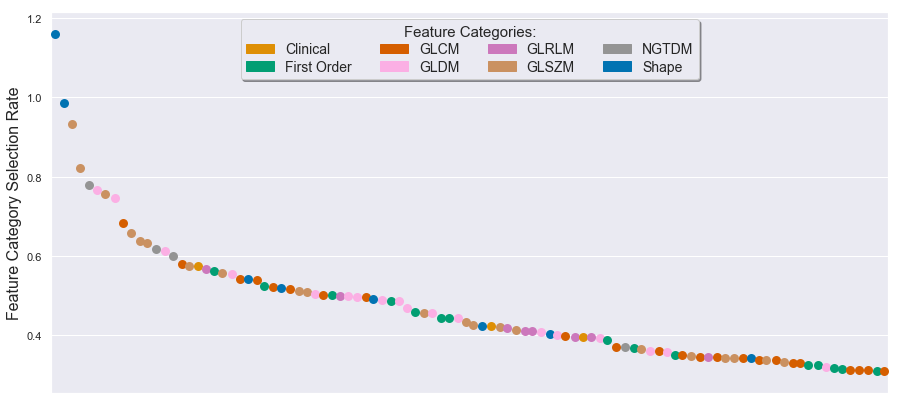

In [36]:
# Observations:
# * Appears NGTDM features are more frequently selected after removing broken slices.
# * All top n features seleceted are also the top n features selected by the best model (Fisher + LightGBM).

n = 100
sub_data = hpv_b_data.iloc[:n, :]
fnames = format_feature_labels(sub_data['labels'])
keys = feature_categories_from_labels(sub_data['labels'])

feature_category_to_colour = {}
for label in np.unique(keys):
    feature_category_to_colour[label] = get_palette_colour(label)     
    
handles = [
    mpatches.Patch(color=feature_category_to_colour[key], label=key) 
    for key in np.unique(keys)
]

plt.figure(figsize=SHAPE_LARGE)
#plt.title(f'Top {n} Most Frequently Selected Features', fontsize=16)
fig = sns.stripplot(
    x='labels',
    y='votes',
    data=sub_data,
    size=9,
    hue=keys,
    palette=feature_category_to_colour
)
feature_id = np.arange(n)
plt.ylabel('Feature Category Selection Rate', fontsize=16)
plt.xlabel('')
plt.xticks([], [])

plt.legend(
    handles=handles,
    title='Feature Categories:', 
    title_fontsize=15,
    loc='upper center', 
    bbox_to_anchor=(0.5, 1),
    fancybox=True, 
    shadow=True, 
    fontsize=14,
    ncol=4,
    labelspacing=0.25
)
plt.savefig(
    './../../figures/feature_importances/hpv_b_selected_feats.png',
    bbox_inches='tight',
    dpi=100, 
)

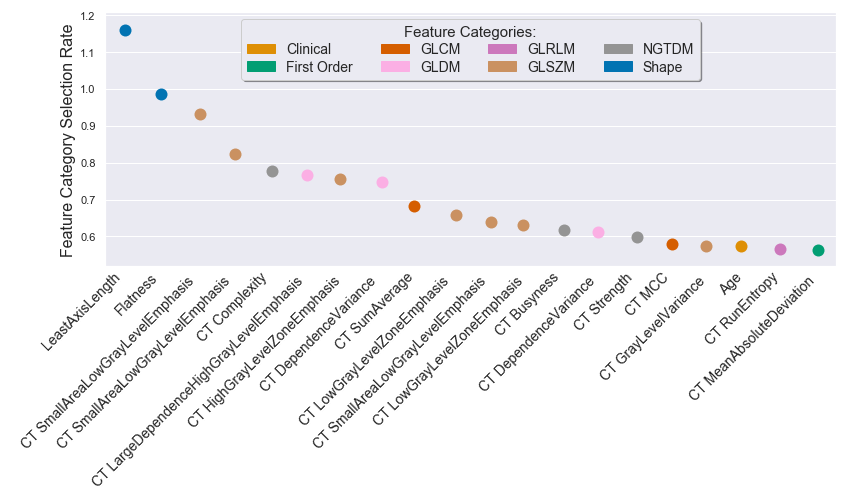

In [37]:
n = 20
sub_data = hpv_b_data.iloc[:n, :]
fnames = format_feature_labels(sub_data['labels'])
keys = feature_categories_from_labels(sub_data['labels'])

feature_category_to_colour = {}
for label in np.unique(keys):
    feature_category_to_colour[label] = get_palette_colour(label)     
    
handles = [
    mpatches.Patch(color=feature_category_to_colour[key], label=key) 
    for key in np.unique(keys)
]

plt.figure(figsize=SHAPE_SMALL)
#plt.title(f'Top {n} Most Frequently Selected Features', fontsize=16)
fig = sns.stripplot(
    y='votes',
    x='labels',
    data=sub_data,
    hue=keys,
    size=12,
    edgecolor='k',
    palette=feature_category_to_colour
)
#markerline, stemlines, baseline = plt.stem(
#    np.arange(n), sub_data['votes'], 
#    linefmt='b-.', markerfmt=' ', bottom=0
#)
#plt.setp(stemlines, 'linewidth', 1)
#plt.setp(baseline, 'linewidth', 0)
feature_id = np.arange(n)
plt.xlabel('')
plt.ylabel('Feature Category Selection Rate', fontsize=16)

plt.xticks(np.arange(len(fnames)), fnames, fontsize=14, 
           rotation=45, ha='right', va='center_baseline')

plt.legend(
    handles=handles,
    title='Feature Categories:', 
    title_fontsize=15,
    loc='upper center', 
    bbox_to_anchor=(0.5, 1),
    fancybox=True, 
    shadow=True, 
    fontsize=14,
    ncol=4,
    labelspacing=0.25
)
plt.tight_layout()
plt.savefig(
    './../../figures/feature_importances/hpv_b_top_b_selected_feats.png',
    bbox_inches='tight',
    dpi=100, 
)

In [38]:
model_name = 'MultiSURFSelection_XGBoost'
hpv_b_model_votes = results_hpv_b[results_hpv_b['experiment_id'] == model_name]['feature_votes']
hpv_b_model_votes = extract_votes(
    hpv_b_model_votes, X_hpv_b, hpv_b_feature_labels, clinical
)

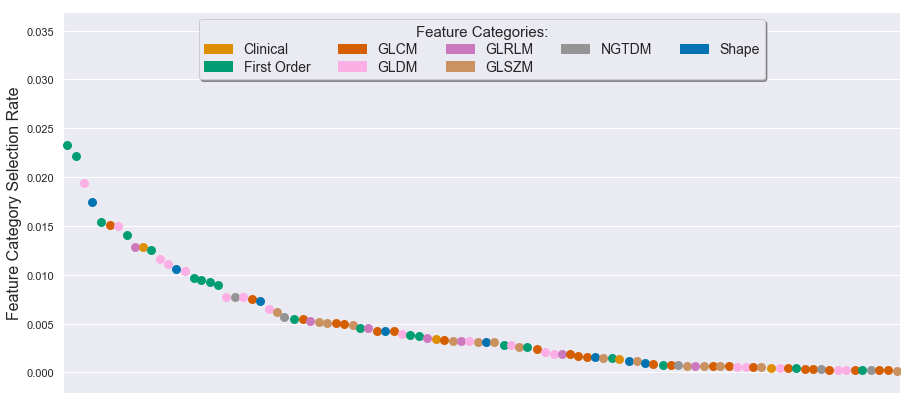

In [39]:
n = 100
sub_data = hpv_b_model_votes.iloc[:n, :]
fnames = format_feature_labels(sub_data['labels'])
keys = feature_categories_from_labels(sub_data['labels'])

feature_category_to_colour = {}
for label in np.unique(keys):
    feature_category_to_colour[label] = get_palette_colour(label)     
    
handles = [
    mpatches.Patch(color=feature_category_to_colour[key], label=key) 
    for key in np.unique(keys)
]

plt.figure(figsize=SHAPE_LARGE)
#plt.title(f'Top {n} Most Frequently Selected Features', fontsize=16)
fig = sns.stripplot(
    x='labels',
    y='votes',
    data=sub_data,
    size=9,
    hue=keys,
    palette=feature_category_to_colour
)
feature_id = np.arange(n)
plt.ylabel('Feature Category Selection Rate', fontsize=16)
plt.xlabel('')
plt.xticks([], [])

plt.legend(
    handles=handles,
    title='Feature Categories:', 
    title_fontsize=15,
    loc='upper center', 
    bbox_to_anchor=(0.5, 1),
    fancybox=True, 
    shadow=True, 
    fontsize=14,
    ncol=5,
    labelspacing=0.25
)
plt.savefig(
    './../../figures/feature_importances/hpv_b_ms_xgb_selected_feats.png',
    bbox_inches='tight',
    dpi=100, 
)

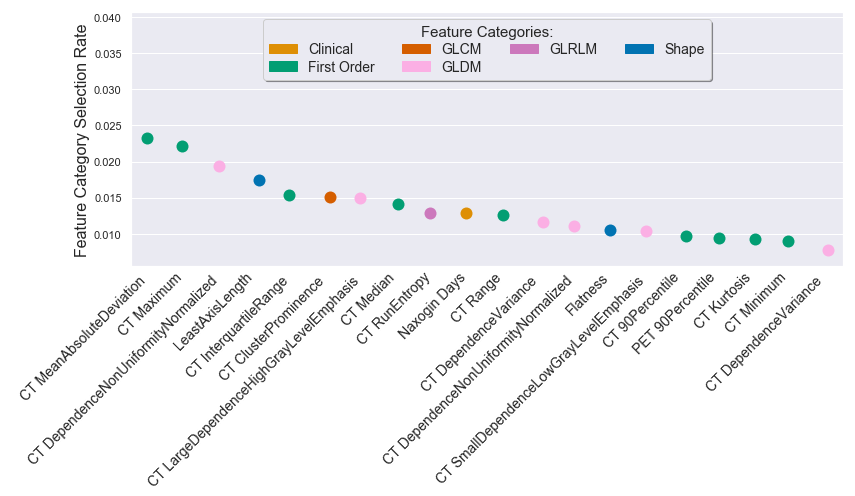

In [40]:
n = 20
sub_data = hpv_b_model_votes.iloc[:n, :]
fnames = format_feature_labels(sub_data['labels'])
keys = feature_categories_from_labels(sub_data['labels'])

feature_category_to_colour = {}
for label in np.unique(keys):
    feature_category_to_colour[label] = get_palette_colour(label)     
    
handles = [
    mpatches.Patch(color=feature_category_to_colour[key], label=key) 
    for key in np.unique(keys)
]

plt.figure(figsize=SHAPE_SMALL)
#plt.title(f'Top {n} Most Frequently Selected Features', fontsize=16)
fig = sns.stripplot(
    y='votes',
    x='labels',
    data=sub_data,
    hue=keys,
    size=12,
    edgecolor='k',
    palette=feature_category_to_colour
)
#markerline, stemlines, baseline = plt.stem(
#    np.arange(n), sub_data['votes'], 
#    linefmt='b-.', markerfmt=' ', bottom=0
#)
#plt.setp(stemlines, 'linewidth', 1)
#plt.setp(baseline, 'linewidth', 0)
feature_id = np.arange(n)
plt.xlabel('')
plt.ylabel('Feature Category Selection Rate', fontsize=16)

plt.xticks(np.arange(len(fnames)), fnames, fontsize=14, 
           rotation=45, ha='right', va='center_baseline')

plt.legend(
    handles=handles,
    title='Feature Categories:', 
    title_fontsize=15,
    loc='upper center', 
    bbox_to_anchor=(0.5, 1),
    fancybox=True, 
    shadow=True, 
    fontsize=14,
    ncol=4,
    labelspacing=0.25
)
plt.tight_layout()
plt.savefig(
    './../../figures/feature_importances/hpv_b_top_b_ms_xgb_selected_feats.png',
    bbox_inches='tight',
    dpi=100, 
)